In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect
from sqlalchemy import extract 

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [11]:
columns = inspector.get_columns('measurement')
columns[0]

{'name': 'id',
 'type': INTEGER(),
 'nullable': False,
 'default': None,
 'autoincrement': 'auto',
 'primary_key': 1}

In [12]:
for col  in columns:
    print(col['name'],  col['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [13]:
columns = inspector.get_columns('station')
for col  in columns:
    print(col['name'],  col['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [14]:
session.query(Station.station, Station.name)

In [15]:
session.query(Station.station, Station.name).all()

[('USC00519397', 'WAIKIKI 717.2, HI US'),
 ('USC00513117', 'KANEOHE 838.1, HI US'),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US'),
 ('USC00517948', 'PEARL CITY, HI US'),
 ('USC00518838', 'UPPER WAHIAWA 874.3, HI US'),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US'),
 ('USC00519281', 'WAIHEE 837.5, HI US'),
 ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US'),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US')]

In [16]:
session.query(Measurement.station, Measurement.date, Measurement.date).limit(5).all()

[('USC00519397', '2010-01-01', '2010-01-01'),
 ('USC00519397', '2010-01-02', '2010-01-02'),
 ('USC00519397', '2010-01-03', '2010-01-03'),
 ('USC00519397', '2010-01-04', '2010-01-04'),
 ('USC00519397', '2010-01-06', '2010-01-06')]

# Exploratory Climate Analysis

In [17]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate last date from Measurement
lastdate = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
lastdate = dt.datetime.strptime(lastdate[0], '%Y-%m-%d')
lastdate

datetime.datetime(2017, 8, 23, 0, 0)

In [18]:
# Calculate the date 1 year ago from the last data point in the database
yearago = lastdate - dt.timedelta(days=366)
yearago

datetime.datetime(2016, 8, 22, 0, 0)

In [19]:
# Perform a query to retrieve the data and precipitation scores
# date >= yearago not working
results = session.query(Measurement.date, Measurement.prcp).\
            filter(Measurement.date>yearago).\
            order_by(Measurement.date.asc()).all()

In [20]:
# Save the query results as a Pandas DataFrame and set the index to the date column
results_df = pd.DataFrame(results, columns = ['date', 'precipitation'])

In [21]:
# Sort the dataframe by date
#results_df.sort_values(by='date')
results_df.set_index('date', inplace=True)
results_df.head()

,precipitation
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02


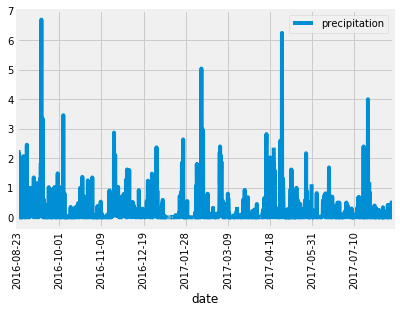

In [22]:
# Use Pandas Plotting with Matplotlib to plot the data
results_df.plot(rot=90)

In [23]:
# ![precipitation](./Images/precipitation.png)

In [24]:
# Use Pandas to calcualte the summary statistics for the precipitation data
results_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [25]:
# ![describe](Images/describe.png)

In [26]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count(Station.station)).all()

[(9)]

In [27]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).\
    all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [28]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
# USC00519281
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == "USC00519281").\
    all()

[(54.0, 85.0, 71.66378066378067)]

In [29]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
result_temp = session.query(Measurement.tobs).\
    filter(Measurement.station == "USC00519281").\
    filter(Measurement.date > yearago).\
    all()

In [30]:
result_temp_df = pd.DataFrame(result_temp,  columns = ['tobs'])

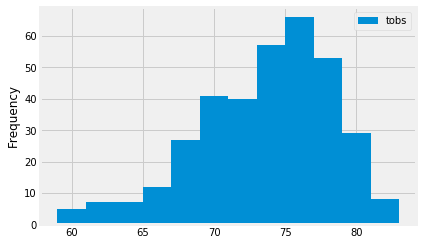

In [31]:
result_temp_df.plot.hist(bins=12)

In [32]:
# ![precipitation](./Images/station-histogram.png)

# Optional: Other Recommended Analyses

# Temperature Analysis I

In [33]:
from scipy.stats import sem, ttest_rel
from sqlalchemy import and_

In [34]:
# Find the most recent year that has observations for all 12 months
lastdate_dec = session.query(Measurement.date).\
                filter(extract('month', Measurement.date)==12).\
                order_by(Measurement.date.desc()).first()

lastdate_dec = dt.datetime.strptime(lastdate_dec[0], '%Y-%m-%d')

year = lastdate_dec.year

In [35]:
# Identify the average temperature in June at all stations across all available years in the dataset. 
# Do the same for December temperature.

june_avg=session.query(extract('year', Measurement.date), func.avg(Measurement.tobs)).\
                        group_by(extract('year', Measurement.date)).\
                        filter(and_(extract('month', Measurement.date)==6,
                                    extract('year', Measurement.date)<=year)).\
                        all()
june_avg

[(2010, 74.92561983471074),
 (2011, 73.93832599118943),
 (2012, 74.0),
 (2013, 74.59907834101382),
 (2014, 75.02790697674419),
 (2015, 74.99014778325123),
 (2016, 75.17525773195877)]

In [36]:
dece_avg=session.query(extract('year', Measurement.date), func.avg(Measurement.tobs)).\
                        group_by(extract('year', Measurement.date)).\
                        filter(extract('month', Measurement.date)==12).\
                        all()
dece_avg

[(2010, 70.20851063829787),
 (2011, 70.82062780269058),
 (2012, 71.18807339449542),
 (2013, 71.09401709401709),
 (2014, 69.89686098654708),
 (2015, 73.42391304347827),
 (2016, 71.13)]

In [37]:
"""
Paired vs. unpaired t-test
Definition
Paired t-test compares study subjects at 2 different times (paired observations of the same subject). 

Unpaired t-test (aka Student’s test) compares two different subjects. 
scipy.stats.ttest_ind

The paired t-test reduces intersubject variability (because it makes comparisons between the same subject), 
and thus is theoretically more powerful than the unpaired t-test.
scipy.stats.mstats.ttest_rel(a, b, axis=0)

The choise was the paired t-test because we have two measurements on the same item.

"""

# t-test
(t_stat, p) = ttest_rel(june_avg[1], dece_avg[1])

In [38]:
t_stat

1.0

In [39]:
# A p-value is the probability that the results from your sample data occurred by chance.
# Low p-value indicates that the data did not occur by chance.

if p < 0.05:
    print(f"p-value = {p}. The differences between the temperatures in June and December are significant.")
else:
    print(f"p-value = {p}. The differences between the temperatures in June and December are due to chance.")

p-value = 0.49999999999999956. The differences between the temperatures in June and December are due to chance.


# Temperature Analysis II

In [40]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [41]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
# Trip Dates = '20xx-03-01', '20xx-03-15'

dt_tripIni = dt.date(2018, 3, 1)
dt_tripEnd = dt.date(2018, 3, 15)
year_ago = dt.timedelta(days=365)

dt_tripIni_1yago = dt_tripIni - year_ago
dt_tripEnd_1yago = dt_tripEnd - year_ago

print(dt_tripIni_1yago, dt_tripEnd_1yago)

2017-03-01 2017-03-15


In [42]:
# Set the veriables to plot
tmin, tavg, tmax = calc_temps(dt_tripIni_1yago, dt_tripEnd_1yago)[0]

print(tmin, tavg, tmax)

62.0 71.1086956521739 82.0


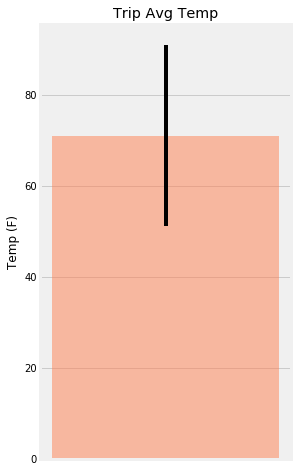

In [43]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

y_err = tmax-tmin

plt.figure(figsize=(4,8))
plt.bar(0, tavg, yerr=y_err, align="center", alpha=0.5, width=1, color="Coral")
plt.ylim = (0, 100)
plt.ylabel("Temp (F)")
plt.title("Trip Avg Temp")
plt.xticks([])
plt.grid(axis='y', linestyle='-', linewidth=1)
plt.show()

# Daily Rainfall Average

In [44]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

rain_fall = session.query(Station.station, func.sum(Measurement.prcp),
                          Station.name, Station.latitude, Station.longitude, Station.elevation).\
    filter(Measurement.station == Station.station).\
    filter(Measurement.date.between(dt_tripIni_1yago, dt_tripEnd_1yago)).\
    group_by(Station.station).\
    order_by(func.sum(Measurement.prcp).desc()).\
    all()

rain_cols = ['Station', 'Rain Amount', 'Station Name', 'Latitude', 'Longitude', 'Elevation']

df_rain_fall = pd.DataFrame(rain_fall, columns=rain_cols)
df_rain_fall.head()

,Station,Rain Amount,Station Name,Latitude,Longitude,Elevation
0,USC00513117,5.76,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
1,USC00519281,5.46,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
2,USC00516128,3.50,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
3,USC00517948,3.04,"PEARL CITY, HI US",21.39340,-157.97510,11.9
4,USC00519397,2.74,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0


In [45]:
## Optional Challenge Assignment

In [46]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [47]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
# Set the start and end date of the trip
# Use the start and end date to create a range of dates
# Stip off the year and save a list of %m-%d strings
# Loop through the list of %m-%d strings and calculate the normals for each date

normals = []
trip_range = pd.date_range(dt_tripIni_1yago, dt_tripEnd_1yago)
trip_range_md = trip_range.strftime('%m-%d')
#normals = [daily_normals(date) for date in trip_range]
for date in trip_range_md:
    normals.append(*daily_normals(date))

In [48]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
df_normals = pd.DataFrame(normals, columns=['tmin', 'tavg', 'tmax']) 
df_normals['date'] = trip_range

# Set index to date
df_normals.set_index('date',inplace=True)

df_normals

,tmin,tavg,tmax
date,,,
2017-03-01,64.0,70.032787,76.0
2017-03-02,61.0,70.366667,78.0
2017-03-03,60.0,70.068966,78.0
2017-03-04,57.0,69.272727,77.0
2017-03-05,60.0,67.890909,76.0
2017-03-06,60.0,69.203390,76.0
2017-03-07,60.0,69.172414,78.0
2017-03-08,59.0,68.724138,78.0
2017-03-09,57.0,68.561404,75.0


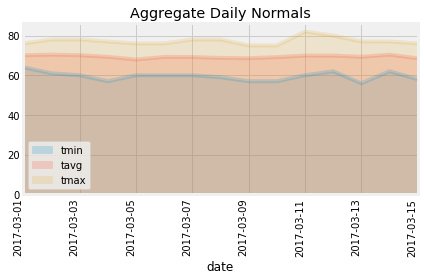

In [49]:
# Plot the daily normals as an area plot with `stacked=False`
df_normals.plot(kind='area', alpha=.2, stacked=False, x_compat=True, rot=90, title="Aggregate Daily Normals")
plt.tight_layout()
plt.savefig("./Images/daily-normals.png")
plt.show()